# Useful packages

In [215]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Loading Steinmetz SPIKING data

In [216]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [217]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [218]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Adding more trial identifiers into 'dat' (Tomáš)

The following four cells will derive **additional variables** about the stimuli and responses and will integrate them into the already existing `alldat` structure. See the text below the last cell for the variables' description.

In [ ]:
#@title Wheel data extraction (made by Tomáš)
def extract_wheel_data(session, trial):
  """ Extracts the wheel speed and calculates the wheel position at each time bin. Requires the SPIKING dataset to be loaded.

  Args:
    session (int): For which session to extract the wheel data.
    trial (int): For which trial to extract the wheel data.
  
  Return:
    wheel_pos: A vector of positions sampled in 10 ms bins
    wheel_speed: A vector of speeds sampled in 10 ms bins
  """

  wheel_speed = alldat[session]['wheel'][0][trial]
  
  wheel_pos = np.zeros(len(wheel_speed))
  for t in range(1,len(wheel_speed)):
    wheel_pos[t] = wheel_pos[t-1] + wheel_speed[t]

  return wheel_pos, wheel_speed

In [ ]:
#@title Stimulus data extraction (made by Tomáš)
def extract_stim_data(session):
  """ Extracts the stimulus information about each trial. Requires the SPIKING dataset to be loaded.

  Args:
    session (int): For which session to extract the stimulus data
    trial (int): For which trial to extract the stimulus data
  
  Return:
    stim_present(bool): A vector of booleans saying whether ANY stimulus was presented (True)
    stim_bilateral (bool): A vector of booleans saying whether BOTH stimuli were presented (True)
    stim_rightOnly (bool): A vector of booleans saying whether ONLY the RIGHT stimulus was presented (True)
    stim_leftOnly (bool): A vector of booleans saying whether ONLY the LEFT stimulus was presented (True)
    stim_diff (float): A vector of differences between the two stimuli contrasts; None means that only one stimulus was presented; positive values mean larger contrast in the right stimulus
  """

  right_contrast = alldat[session]['contrast_right']
  left_contrast = alldat[session]['contrast_left']

  stim_present = (right_contrast + left_contrast) > 0
  stim_bilateral = np.minimum(right_contrast, left_contrast) > 0
  
  stim_rightOnly = np.zeros_like(right_contrast)
  for i in range(len(right_contrast)):
    stim_rightOnly[i] = right_contrast[i] > 0 and left_contrast[i] == 0
  
  stim_leftOnly = np.zeros_like(left_contrast)
  for i in range(len(left_contrast)):
    stim_leftOnly[i] = left_contrast[i] > 0 and right_contrast[i] == 0
  
  stim_diff = right_contrast - left_contrast
  for i in range(len(stim_diff)):
     if stim_bilateral[i] == False:
       stim_diff[i] = None

  return stim_present, stim_bilateral, stim_rightOnly, stim_leftOnly, stim_diff

In [ ]:
#@title Accuracy data extraction (made by Phil)
def compute_accuracy(data = alldat, session = list(np.arange(0, 39, 1))):
    """ 
    arguments:
    session: a list of session numbers to evaluate.  Default is all session in dat.
    
    output:
    TBD
    """
    accuracy_all = []
    accuracy_move_all = []
    accuracy_bool_all = []
    accuracy_bool_move_all = []
    indMove_all = []
    
    for i, run in enumerate(session):
        # get relevant data
        
        #set_trace()
        response = data[i]['response'] # right - nogo - left (-1, 0, 1)
        vis_right = data[i]['contrast_right'] # 0 - low - high
        vis_left = data[i]['contrast_left'] # 0 - low - high

        #initialize empty boolean accuracy object
        accuracy_bool = np.zeros(len(response))

        # the following are the correct responses:
        # if vis_left > vis_right : response >0
        # if vis_left < vis_right : response <0
        # if vis_left = vis_right : response =0
        # trials below red line are incorrect
        is_correct = np.sign(response)==np.sign(vis_left-vis_right)
        accuracy_bool[is_correct] = 1
        accuracy = np.sum(accuracy_bool)/len(accuracy_bool)

        # Compute accuracy for only movement trials
        indMove = np.logical_or(vis_right > vis_left, vis_left > vis_right)

        # create vectors only of movement trials
        response_move = response[indMove]
        vis_right_move = vis_right[indMove]
        vis_left_move = vis_left[indMove]

        # compute accuracy only for movement trials
        accuracy_bool_move = np.zeros(len(response_move))

        is_correct_move = np.sign(response_move)==np.sign(vis_left_move - vis_right_move)
        accuracy_bool_move[is_correct_move] = 1
        accuracy_move = np.sum(accuracy_bool_move)/len(accuracy_bool_move)

        #set_trace()
        accuracy_all.append(accuracy)
        accuracy_move_all.append(accuracy_move)
        accuracy_bool_all.append(accuracy_bool)
        accuracy_bool_move_all.append(accuracy_bool_move)
        indMove_all.append(indMove)
        
    return ([accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove_all])

In [ ]:
#@title Happy neurons identification (made by Darcy)
def happy_neurons(session_data, brain_areas):
  """ 
    arguments:
    inputs:
    session_data: the data from one session (i.e., 3D data in alldat[asession]['spks'])
    brain_areas: array of the brain areas for each neuron in the session data
    
    output:
    neurons_to_use: a boolean array as long as the first dim of session data (the neuron 
    dimension). Values of True indicate neuron is the upper 60% of the firing count distribution
    for a given region. False indicates neuron is not responsive enough, falls below that threshold.
  """

  all_areas = np.unique(brain_areas)
  neurons_to_use = np.zeros(np.shape(session_data)[0],dtype=bool)
  region_quantile40 = np.zeros(len(all_areas))

  for iregion in range(len(all_areas)-1):
    region_data = session_data[brain_areas==all_areas[iregion],:,:]
    # get the value at quantile 40 of distribution (we will remove neurons below that threshold)
    spike_counts = np.sum(np.mean(region_data,axis=1),axis=1)
    ranked_neurons = np.sort(spike_counts)
    region_quantile40[iregion] = np.quantile(ranked_neurons,.40) # get value at 40th quantile for the region

  total_spikes = np.sum(np.mean(session_data,axis=1),axis=1)
  for ineuron in range(np.shape(session_data)[0]):
    region_its_in = np.where(brain_areas[ineuron]==all_areas)
    if total_spikes[ineuron] < region_quantile40[region_its_in] or total_spikes[ineuron] == 0 :
      neurons_to_use[ineuron] = False
    else:
      neurons_to_use[ineuron] = True

  return (neurons_to_use)

# example
dat = alldat[2]
neurons_to_use = happy_neurons(dat['spks'],dat['brain_area'])
print(neurons_to_use[:10])

[False  True False False  True False False  True  True False]


In [ ]:
#@title Integrating new variables into the alldat structure (made by Tomáš)
def make_identifiers(data = alldat):
  """ 
  Updates the 'alldat' structure by adding new variables as keys into the
  dictionaries under each session. For dat=alldat[k], you will be able to
  access the added variables the same way as all other variables already present
  in the alldat structure.
  
  IMPORTANT: See the text under this cell for description of the new variables.
  """
  for session in range(len(data)):
    dat = data[session]
    n_trials = len(dat['response'])

    # Setting up wheel_pos and wheel_speed
    wheel_pos = np.empty((n_trials,250)) # hardcoded 250 as the universal number of timepoints in each trial
    wheel_speed = np.empty((n_trials,250)) # hardcoded 250 as the universal number of timepoints in each trial
    for trial in range(n_trials):
      this_wheel_pos, this_wheel_speed = extract_wheel_data(session, trial)
      wheel_pos[trial] = this_wheel_pos
      wheel_speed[trial] = this_wheel_speed
    dat['wheel_pos'] = wheel_pos
    dat['wheel_speed'] = wheel_speed # This is the same as dat['wheel']; included again with different name to avoid ambiguity
    
    # Setting up stim_present, stim_bilateral, stim_rightOnly, stim_leftOnly, and stim_diff
    stim_present, stim_bilateral, stim_rightOnly, stim_leftOnly, stim_diff = extract_stim_data(session)
    dat['stim_present'] = stim_present
    dat['stim_bilateral'] = stim_bilateral
    dat['stim_rightOnly'] = stim_rightOnly
    dat['stim_leftOnly'] = stim_leftOnly
    dat['stim_diff'] = stim_diff

    # Setting up response_side, response_correct
    dat['response_side'] = dat['response'] # This is the same as dat['response']; included again with different name to avoid ambiguity
    
    accuracy_all, accuracy_move_all, accuracy_bool_all, accuracy_bool_move_all, indMove = compute_accuracy()
    dat['accuracy_all'] = accuracy_all[session]
    dat['accuracy_moveOnly'] = accuracy_move_all[session]
    dat['response_correct_all'] = accuracy_bool_all[session]
    dat['response_correct_moveOnly'] = accuracy_bool_move_all[session]
    dat['movement_required'] = indMove[session]

    # Setting up happy neuron identifiers (i.e., identifier of neurons with firing rate higher than certain value)
    neurons_to_use = happy_neurons(dat['spks'], dat['brain_area'])
    dat['happy_neurons'] = neurons_to_use


make_identifiers()

After running the `make_trial_identifiers()` function in the last cell, the `dat=alldat[k]` now contains these additional variables:

*   `dat['wheel_pos']`: trial-by-timepoint array of wheel positions
*   `dat['wheel_speed']`: trial-by-timepoint array of wheel speeds (similar to `dat['wheel']` but without the redundant dimension and ambiguous name)
*   `dat['stim_present']`: n_trials-long vector of booleans indicating whether **ANY** stimulus was presented in the given trial
*   `dat['stim_bilateral']`: n_trials-long vector of booleans indicating whether **BOTH** stimuli were presented in the given trial
*   `dat['stim_rightOnly']:` n_trials-long vector of booleans indicating whether **only the RIGHT** stimulus was presented
*   `dat['stim_leftOnly']`: n_trials-long vector of booleans indicating whether **only the LEFT** stimulus was presented
*   `dat['stim_diff']`: n_trials-long vector of differences between the two stimuli contrasts; *nan* means that only one stimulus was presented; positive values mean larger contrast in the right stimulus, negative values mean larger contrast in the left stimulus
*   `dat['response_side']`: n_trials-long vector of directions the mouse turned the wheel in (-1: counterclockwise, 1: clockwise, 0: no response); same as `dat['response']` but with unambiguous name
*   `dat['accuracy_all']`: percentage of correct responses of the mouse across all trials (one scalar per session)
*   `dat['accuracy_moveOnly']`: percentage of correct responses of the mouse for trials **requiring movement** only (one scalar per session)
*   `dat['response_correct_all']`: n_trials-long vector of correct responses (1) and incorrect responses (0) in all trials
*   `dat['response_correct_moveOnly']`: vector of variable length of correct responses (1) and incorrect responses (0) in trials **requiring movement** only
*   `dat['movement_required']`: n_trials-long vector of booleans indicating whether movement was required in the given trial
*   `dat['happy_neurons']`: boolean vector of length corresponding to the number of neurons indicating whether the neuron's firing rate is sufficient for inclusion into the dataset

# PCA

In [ ]:
#@title Packages for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn.decomposition import FactorAnalysis as FA
from scipy.ndimage import gaussian_filter1d

In [ ]:
#@title Reshaping function (WIP, don't use)
def reshape(key, level, session):
  if not isinstance(key, str):
    raise Warning("Argument 'key' must be a string.")
  if not level in ['ses', 'trial', 'bin']:
    raise Warning("Argument 'level' must be either 'ses', 'trial' or 'bin'.")
  if not isinstance(session, int):
    raise Warning("Argument 'session' must be an integer between 0 and 38.")
  
  reshaped_all = np.array([])

  dat = alldat[session]

  if level == 'bin':
    reshaped = dat[key]
    reshaped = reshaped.reshape(reshaped.shape[0]*reshaped.shape[1])
  
  if level == 'trial':
    reshaped = dat[key]
    reshaped = np.array([[i]*250 for i in reshaped]).reshape(reshaped.shape[0]*250)

  if level == 'session':
    reshaped = dat[key]
    reshaped = np.array(list(session)*len(dat['response'])*250)
    
    reshaped_all = np.append(reshaped_all, reshaped)
  
  return reshaped_all


wheel_reshaped = reshape('wheel_pos', 'bin', 0)
print(wheel_reshaped.shape)

(0,)


In [ ]:
#@title Data set up (for one session only, will NOT work further, don't use)
session = 0

dat = alldat[session]
n_trials = len(dat['response'])
spikes = dat['spks']
spikes = spikes.reshape(spikes.shape[0], spikes.shape[1]*spikes.shape[2])

# example of reshaped variables
time_reshaped = list(range(250))*n_trials # number of time bin (level of time bins)

wheel_pos = dat['wheel_pos'] # you can do changes to the variable here (e.g., indexing which trials we want to include)
wheel_pos_reshaped = wheel_pos.reshape(wheel_pos.shape[0]*wheel_pos.shape[1]) # wheel positions (level of time bins) 

response_correct_all_reshaped = dat['response_correct_all'] # you can do changes to the variable here (e.g., indexing which trials we want to include)
response_correct_all_reshaped = np.array([[i]*250 for i in response_correct_all_reshaped]).reshape(response_correct_all_reshaped.shape[0]*250) # correct/incorrect (level of trials)

In [ ]:
#@title Function for calculating mean per neuron per time bin across trials (made by Ronan)
def mean_spikes_per_neuron(spike_data):
  '''
  Averages spiking data across all trials in given neuron x trials np array
  '''

  mean_spikes = np.zeros((len(spike_data), 250))

  for neuron in range(len(spike_data)):
    mean_spikes[neuron] = np.mean(spike_data[neuron][:], axis = 0)

  return mean_spikes

In [ ]:
#@title Data set up (across sessions)

spikes_to_analyze = np.empty((0,500))
brain_areas_for_happy_neurons = np.empty((0,))

for session in range(len(alldat)):
  dat = alldat[session]
  spikes = gaussian_filter1d(dat['spks'][dat['happy_neurons'],:,:].astype('float'), 1)
  spikes_moveOnly = spikes[:,dat['movement_required'],:]
  correct_moveOnly = np.array(dat['response_correct_moveOnly'], dtype=np.bool)
  incorrect_moveOnly = np.logical_not(correct_moveOnly)

  spikes_moveOnly_correct = mean_spikes_per_neuron(spikes_moveOnly[:,correct_moveOnly,:])
  spikes_moveOnly_incorrect = mean_spikes_per_neuron(spikes_moveOnly[:,incorrect_moveOnly,:])
  spikes_moveOnly_all = np.hstack([spikes_moveOnly_correct, spikes_moveOnly_incorrect])

  spikes_to_analyze = np.vstack([spikes_to_analyze, spikes_moveOnly_all])

  # adding brain regions
  brain_areas_for_happy_neurons = np.hstack([brain_areas_for_happy_neurons, dat['brain_area'][dat['happy_neurons']].T])

print(spikes_to_analyze.shape)
print(brain_areas_for_happy_neurons.shape)

(22346, 500)
(22346,)


15998


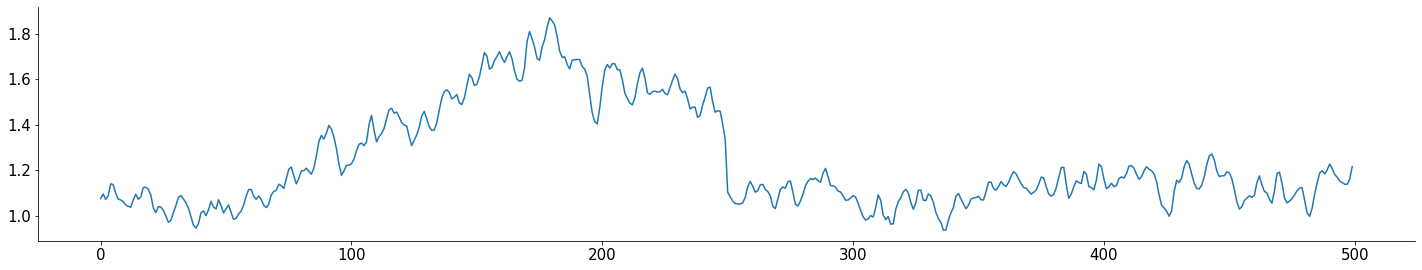

In [ ]:
#@title Plotting the smoothed activity for the neuron with largest number of responses
happiest_neuron = np.argmax(spikes_to_analyze.mean(axis=1))

#spk_smooth = gaussian_filter1d(dat['spks'][happiest_neuron,42,:].astype('float'), 2)

plt.plot(spikes_to_analyze[happiest_neuron])
print(happiest_neuron)

In [ ]:
#@title Performs the dimensionality reduction
dim_reduced = PCA(n_components=20) # you can change the method here
dim_reduced.fit(spikes_to_analyze.T)
embed = dim_reduced.fit_transform(spikes_to_analyze.T)

([<matplotlib.axis.XTick at 0x7fa00af205d0>,
 <a list of 20 Text major ticklabel objects>)

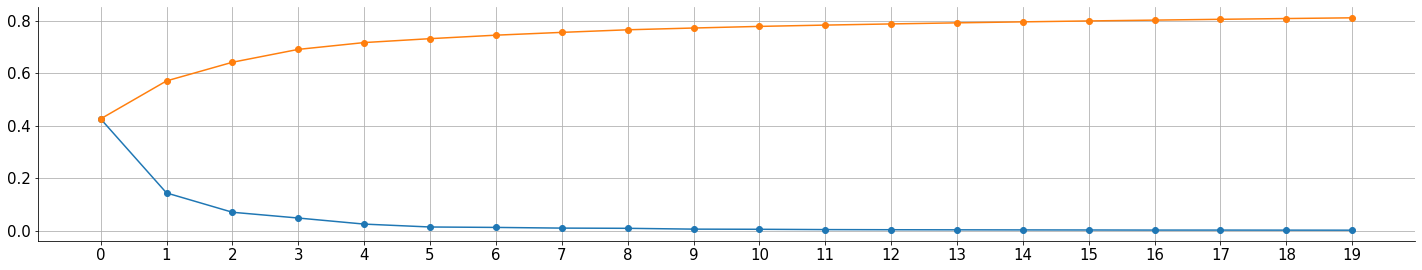

In [ ]:
#@title Scree plot & cumulative variance explained 
plt.plot(dim_reduced.explained_variance_ratio_, marker = 'o')
plt.plot(np.cumsum(dim_reduced.explained_variance_ratio_), marker = 'o')
plt.grid()
plt.xticks(range(20))

# PCA plotting

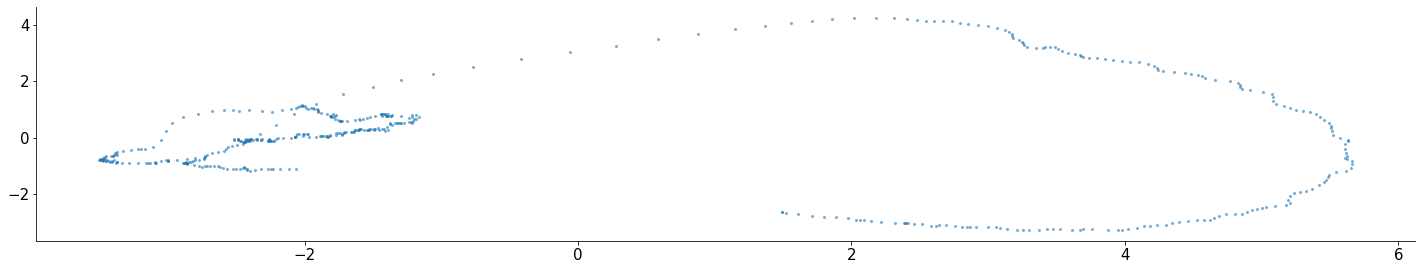

In [ ]:
#@title Plots the embedding
plt.scatter(embed[:,0], embed[:,1], s  = 4, cmap = 'RdBu', alpha = 0.5)

(-6.0, 6.0)

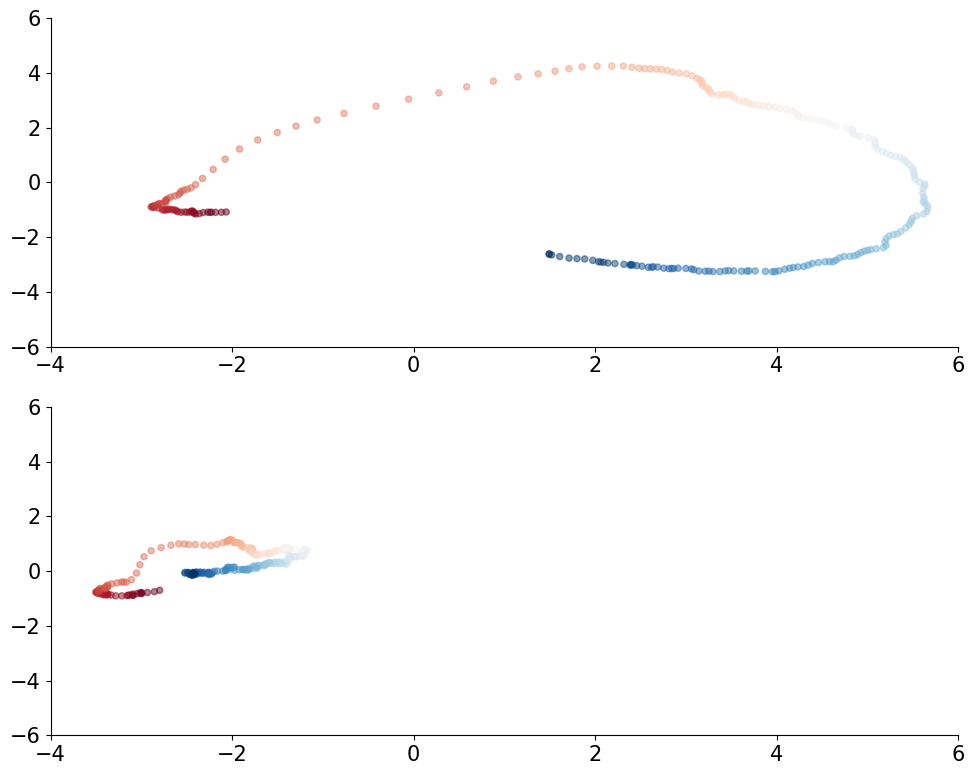

In [ ]:
# plt.autoscale = False
# plt.figure()
f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), dpi=100)
ax1.scatter(embed[:250,0], embed[:250,1], c = range(250), s  = 20, cmap = 'RdBu', alpha = 0.5)
ax2.scatter(embed[250:500,0], embed[250:500,1], c = range(250), s  = 20, cmap = 'RdBu', alpha = 0.5)

ax1.set_xlim([-4,6])
ax2.set_xlim([-4,6])
ax1.set_ylim([-6,6])
ax2.set_ylim([-6,6])

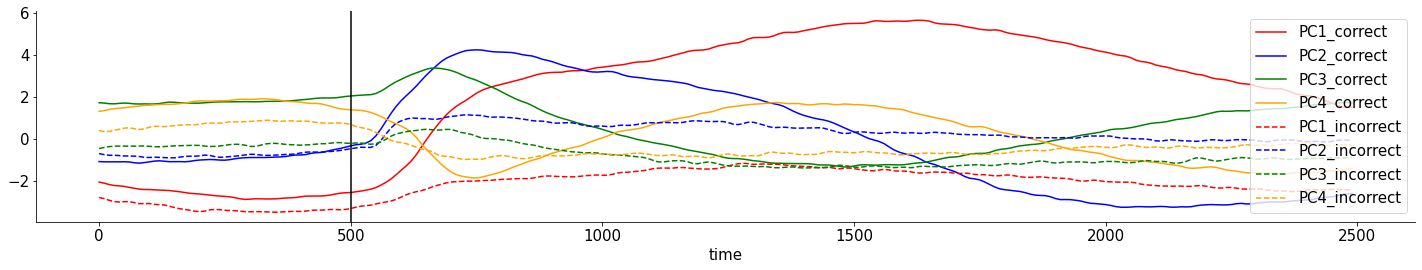

In [229]:
plt.plot(embed[:250,0], label = 'PC1_correct', c = 'red', linestyle = 'solid')
plt.plot(embed[:250,1], label = 'PC2_correct', c = 'blue', linestyle = 'solid')
plt.plot(embed[:250,2], label = 'PC3_correct', c = 'green', linestyle = 'solid')
plt.plot(embed[:250,3], label = 'PC4_correct', c = 'orange', linestyle = 'solid')
plt.plot(embed[250:500,0], label = 'PC1_incorrect', c = 'red', linestyle = 'dashed')
plt.plot(embed[250:500,1], label = 'PC2_incorrect', c = 'blue', linestyle = 'dashed')
plt.plot(embed[250:500,2], label = 'PC3_incorrect', c = 'green', linestyle = 'dashed')
plt.plot(embed[250:500,3], label = 'PC4_incorrect', c = 'orange', linestyle = 'dashed')
plt.legend(loc = 'right')
plt.xlabel('time')
plt.xticks(ticks = np.linspace(0,250,6).astype(int), labels = np.linspace(0,2500,6).astype(int))
plt.axvline(x = 50, c = 'black')

# Projecting principal components back on the data

In [ ]:
loadings = dim_reduced.components_.T * np.sqrt(dim_reduced.explained_variance_)
brain_areas_uniques = np.unique(brain_areas_for_happy_neurons)
print(brain_areas_uniques)

['ACA' 'ACB' 'APN' 'AUD' 'BLA' 'BMA' 'CA' 'CA1' 'CA2' 'CA3' 'CL' 'COA'
 'CP' 'DG' 'DP' 'EP' 'EPd' 'GPe' 'IC' 'ILA' 'LD' 'LGd' 'LH' 'LP' 'LS'
 'LSc' 'LSr' 'MB' 'MD' 'MEA' 'MG' 'MOp' 'MOs' 'MRN' 'MS' 'NB' 'OLF' 'ORB'
 'ORBm' 'OT' 'PAG' 'PIR' 'PL' 'PO' 'POL' 'POST' 'PT' 'RN' 'RSP' 'RT'
 'SCig' 'SCm' 'SCs' 'SCsg' 'SI' 'SNr' 'SPF' 'SSp' 'SSs' 'SUB' 'TH' 'TT'
 'VAL' 'VISa' 'VISam' 'VISl' 'VISp' 'VISpm' 'VISrl' 'VPL' 'VPM' 'ZI'
 'root']


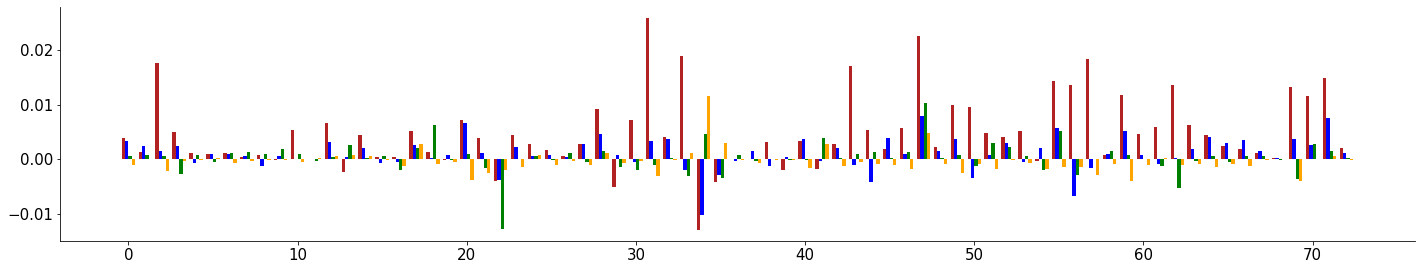

In [219]:
tick = 0
area_list = brain_areas_uniques#['VISp', 'MOp', 'MOs']

for area in area_list:
  loadings_for_areas = loadings[brain_areas_for_happy_neurons == area]
  area_mean = np.mean(loadings_for_areas, axis = 0)  
  plt.bar(tick-0.3, area_mean[0], width = 0.2, color = 'firebrick')
  plt.bar(tick-0.1, area_mean[1], width = 0.2, color = 'blue')
  plt.bar(tick+0.1, area_mean[2], width = 0.2, color = 'green')
  plt.bar(tick+0.3, area_mean[3], width = 0.2, color = 'orange')
  #plt.legend()
  tick += 1

['LH' 'VAL' 'VPL' 'NB' 'MRN' 'SPF' 'AUD' 'SI' 'MG' 'EPd' 'LGd' 'MEA'
 'SCig' 'TT' 'MOp' 'VISl' 'BMA' 'MB' 'ORB' 'VISa' 'COA' 'OT' 'PAG' 'VISrl'
 'ILA' 'LSc' 'TH' 'SSp' 'LP' 'ORBm' 'PL' 'RSP' 'root' 'DP' 'MOs' 'POST'
 'CP' 'VISam' 'EP' 'VISpm' 'LS' 'ACA' 'APN' 'VISp' 'SCsg' 'BLA' 'OLF'
 'SUB' 'ACB' 'RT' 'CL' 'LD' 'PO' 'CA2' 'CA' 'LSr' 'PT' 'POL' 'CA1' 'MD'
 'ZI' 'SSs' 'CA3' 'GPe' 'SCs' 'DG' 'VPM' 'SCm' 'PIR' 'MS' 'SNr' 'IC' 'RN']


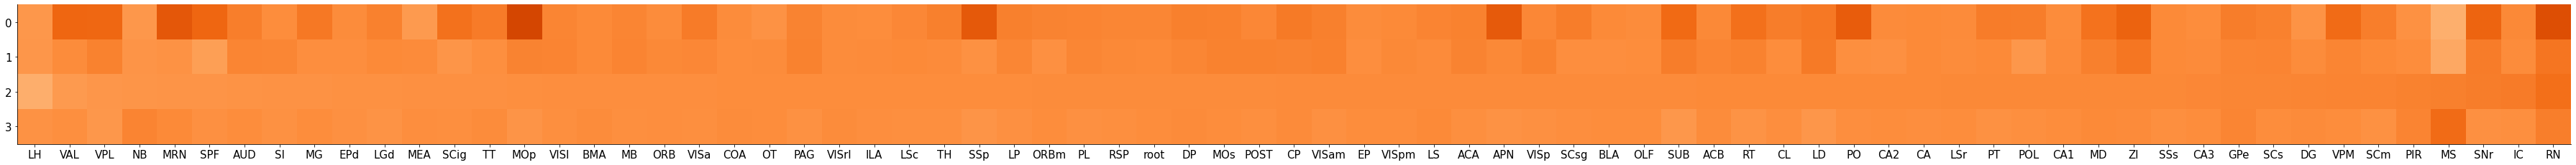

In [228]:
area_list = brain_areas_uniques#['MOp', 'MOs', 'SNr', 'ZI', 'CP', 'VISp']
indexes = []
for thisArea in area_list:
  thisIndex = np.where(brain_areas_uniques == thisArea)
  indexes.append(thisIndex[0].tolist()[0])


area_list = brain_areas_uniques[indexes]
area_means = np.zeros((area_list.shape[0], 4))

for a, area in enumerate(area_list):
  loadings_for_areas = loadings[brain_areas_for_happy_neurons == area]
  area_mean = np.mean(loadings_for_areas, axis = 0)  
  area_means[a] = area_mean

f, ax = plt.subplots(1,1,figsize=(50,20))
ax.imshow(area_means[np.argsort(area_means[:,2])].T, cmap = 'Oranges', vmax=0.05, vmin=-0.05, aspect=1)
plt.tight_layout()
ax.set_xticks(np.linspace(0, len(area_list)-1, len(area_list)))
ax.set_xticklabels(area_list[np.argsort(area_means[:,2])])
print(area_list[np.argsort(area_means[:,2])])

Text(0, 0.5, 'PC2')

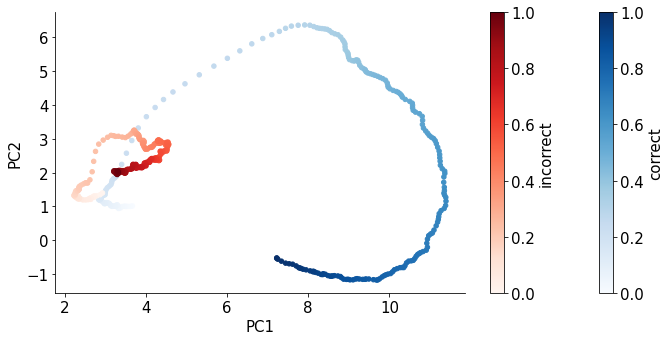

In [ ]:
#@title Back-projecting the PC1 and PC2 on the whole brain (made by Maz, adapted by Tomáš)
PC1 = dim_reduced.components_[0,:]
PC1 = PC1 / np.sum(PC1**2)**.5

PC2 = dim_reduced.components_[1,:]
PC2 = PC2 / np.sum(PC2**2)**.5

spikes_correct_PC1 = PC1 @ spikes_to_analyze[:,:250]
spikes_correct_PC2 = PC2 @ spikes_to_analyze[:,:250]

spikes_incorrect_PC1 = PC1 @ spikes_to_analyze[:,250:]
spikes_incorrect_PC2 = PC2 @ spikes_to_analyze[:,250:]

f, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(spikes_correct_PC1, spikes_correct_PC2, c = range(250), s  = 20, cmap = 'Blues', label = 'correct')
f.colorbar(cm.ScalarMappable(norm=None, cmap='Blues'), label = 'correct')
ax.scatter(spikes_incorrect_PC1, spikes_incorrect_PC2, c = range(250), s  = 20, cmap = 'Reds', label = 'incorrect')
f.colorbar(cm.ScalarMappable(norm=None, cmap='Reds'), label = 'incorrect')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

Text(0, 0.5, 'PC2')

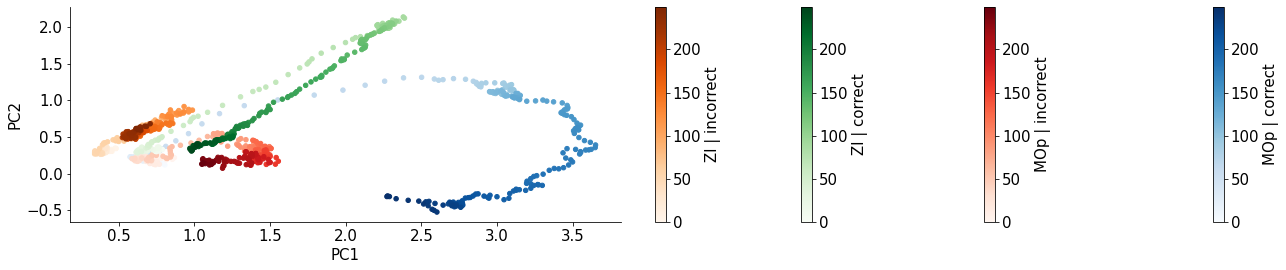

In [ ]:
#@title Back-projecting the PC1 and PC2 on specific areas (made by Maz)
for area in ['MOp', 'ZI']:
  PC1 = dim_reduced.components_[0, brain_areas_for_happy_neurons == area]
  PC1 = PC1 / np.sum(PC1**2)**.5
  
  PC2 = dim_reduced.components_[1, brain_areas_for_happy_neurons == area]
  PC2 = PC2 / np.sum(PC2**2)**.5

  spikes_correct_PC1 = PC1 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,:250]
  spikes_correct_PC2 = PC2 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,:250]

  spikes_incorrect_PC1 = PC1 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,250:]
  spikes_incorrect_PC2 = PC2 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,250:]

  cmapCorrect = 'Blues' if area == 'MOp' else 'Greens'
  cmapIncorrect = 'Reds' if area == 'MOp' else 'Oranges'

  plt.scatter(spikes_correct_PC1, spikes_correct_PC2, c = range(250), s  = 20, cmap = cmapCorrect, label = area + " | correct")
  plt.colorbar(label = area + ' | correct')
  plt.scatter(spikes_incorrect_PC1, spikes_incorrect_PC2, c = range(250), s  = 20, cmap = cmapIncorrect, label = area + " | incorrect")
  plt.colorbar(label = area + ' | incorrect')

plt.xlabel('PC1')
plt.ylabel('PC2')


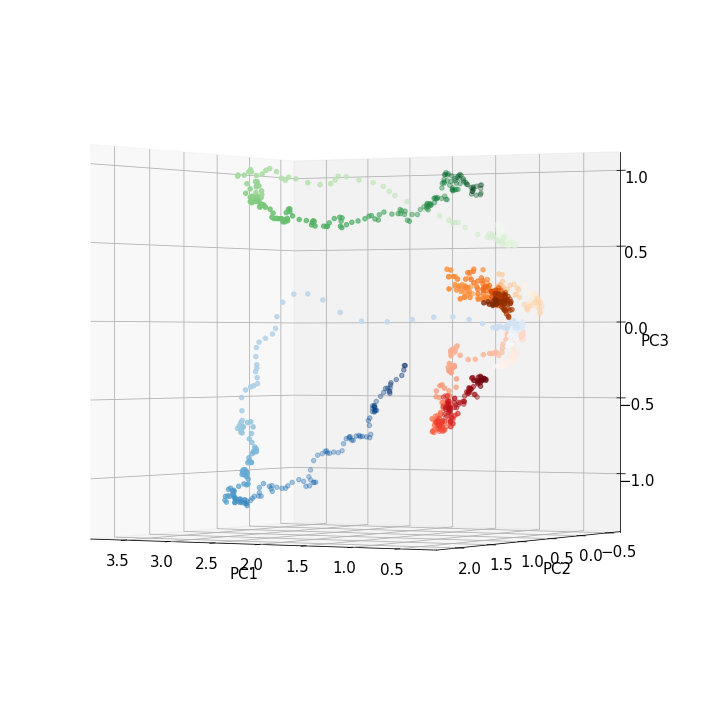

In [225]:
#@title Back-projecting the PC1, PC2, and PC3 on specific areas (made by Maz, adapted by Tomáš)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for area in ['MOp', 'ZI']:
  PC1 = dim_reduced.components_[0, brain_areas_for_happy_neurons == area]
  PC1 = PC1 / np.sum(PC1**2)**.5
  
  PC2 = dim_reduced.components_[1, brain_areas_for_happy_neurons == area]
  PC2 = PC2 / np.sum(PC2**2)**.5

  PC3 = dim_reduced.components_[2, brain_areas_for_happy_neurons == area]
  PC3 = PC3 / np.sum(PC3**2)**.5

  spikes_correct_PC1 = PC1 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,:250]
  spikes_correct_PC2 = PC2 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,:250]
  spikes_correct_PC3 = PC3 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,:250]

  spikes_incorrect_PC1 = PC1 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,250:]
  spikes_incorrect_PC2 = PC2 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,250:]
  spikes_incorrect_PC3 = PC3 @ spikes_to_analyze[brain_areas_for_happy_neurons == area,250:]

  cmapCorrect = 'Blues' if area == 'MOp' else 'Greens'
  cmapIncorrect = 'Reds' if area == 'MOp' else 'Oranges'

  ax.scatter(spikes_correct_PC1, spikes_correct_PC2, spikes_correct_PC3, c = range(250), s  = 20, cmap = cmapCorrect, label = area + " | correct")
  #plt.colorbar(label = area + ' | correct')
  ax.scatter(spikes_incorrect_PC1, spikes_incorrect_PC2, spikes_incorrect_PC3, c = range(250), s  = 20, cmap = cmapIncorrect, label = area + " | incorrect")
  #plt.colorbar(label = area + ' | incorrect')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(elev=0, azim=120)


# Logistic regression

In [ ]:
print(alldat[0]['spks'].shape, alldat[0]['response_side'].shape, alldat[0]['response_correct_all'].shape)

(734, 214, 250) (214,) (214,)


In [ ]:
#@title Prepare data for left/right logistic regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

dat = alldat[0]
spikes_correct = dat['spks'][dat['brain_area'] == 'VISp',:,:][:,dat['response_correct_all'] == 1,:]
spikes_correct = np.reshape(spikes_correct, (spikes_correct.shape[0] * spikes_correct.shape[2], spikes_correct.shape[1])).T
print(spikes_correct.shape)

spikes_incorrect = dat['spks'][dat['brain_area'] == 'VISp',:,:][:,dat['response_correct_all'] == 0,:]
spikes_incorrect = np.reshape(spikes_incorrect, (spikes_incorrect.shape[0] * spikes_incorrect.shape[2], spikes_incorrect.shape[1])).T
print(spikes_incorrect.shape)

label_correct = dat['response_side'][dat['response_correct_all'] == 1]
print(label_correct.shape)

label_incorrect = dat['response_side'][dat['response_correct_all'] == 0]
print(label_incorrect.shape)

(139, 44500)
(75, 44500)
(139,)
(75,)


In [ ]:
#@title Run logistic regression for correct trials
#X_corr, y_corr = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, multi_class='multinomial').fit(spikes_correct[:100], label_correct[:100])
print(clf.predict(spikes_correct[100:, :]))
# clf.predict_proba(X[:2, :])
print(clf.score(spikes_correct[100:,:], label_correct[100:]))
print(label_correct[100:])

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1.]
0.2564102564102564
[ 0.  1.  0. -1.  1. -1. -1.  0.  1.  0.  1.  0.  1.  0.  1. -1.  0.  1.
 -1.  1.  1.  1. -1.  1.  1.  1.  0.  0. -1.  0. -1.  0.  1.  1.  0.  1.
  1.  0.  1.]


In [ ]:
#@title Run logistic regression for incorrect trials
#X_corr, y_corr = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, multi_class='multinomial').fit(spikes_incorrect[:50], label_incorrect[:50])
print(clf.predict(spikes_incorrect[50:, :]))
# clf.predict_proba(X[:2, :])
print(clf.score(spikes_incorrect[50:,:], label_incorrect[50:]))
print(label_incorrect[50:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
0.68
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 1.]
